## Text-To-Image Generation via Masked Generative Transformers
1.   **Algorithm** (Muse-Super Resolution)
2.   **Library** (torch, muse_maskgit_pytorch)
3.   **Result** (High-Quality Text-to-Image Conversion Using Masked Generative Transformers)


> **Installing the Required Libraries**



In [1]:
pip install muse-maskgit-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 10.4 MB/s eta 0:00:00



> **Train VAE**
          
          For training the VAE in super-resolution mode, the pre-trained file from the low-resolution mode is used.






> **Pass the Trained VQGanVAE and a Transformer to MaskGit**



In [2]:
import torch
from muse_maskgit_pytorch import VQGanVAE, MaskGit, MaskGitTransformer
import torch.nn.functional as F

# first instantiate your vae

vae = VQGanVAE(
    dim = 256,
    codebook_size = 65536
).cuda()

vae.load('/content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/vae_model.pt')

# then you plug the vae and transformer into your MaskGit as so

# (1) create your transformer / attention network

transformer = MaskGitTransformer(
    num_tokens = 65536,       # must be same as codebook size above
    seq_len = 1024,            # must be equivalent to fmap_size ** 2 in vae
    dim = 512,                # model dimension
    depth = 2,                # depth
    dim_head = 64,            # attention head dimension
    heads = 8,                # attention heads,
    ff_mult = 4,              # feedforward expansion factor
    t5_name = 't5-small',     # name of your T5
)

# (2) pass your trained VAE and the base transformer to MaskGit

superres_maskgit = MaskGit(
    vae = vae,
    transformer = transformer,
    cond_drop_prob = 0.25,
    image_size = 512,                     # larger image size
    cond_image_size = 256,                # conditioning image size <- this must be set
).cuda()


/usr/local/lib/python3.10/dist-packages/muse_maskgit_pytorch/vqgan_vae.py:419: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(str(path))


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [3]:
# ready your training text and images
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
import os

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

excel_file = '/content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/Image Number-Text-High Res.xlsx'
data = pd.read_excel(excel_file)

images = []
texts = data['text'].tolist()

for image_file in data['image_filename']:
    image = Image.open(f'/content/drive/MyDrive/Text To Image Generation/Muse-Masked Generative Transformers/Images-High Res/{image_file}').convert("RGB")
    image = transform(image)
    images.append(image)

images = torch.stack(images).cuda()


# feed it into your maskgit instance, with return_loss set to True

loss = superres_maskgit(
    images,
    texts = texts
)

loss.backward()

# do this for a long time on much data
# then...



model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]



> **Generating New Images with Muse**


In [4]:
generated_images = superres_maskgit.generate(
    texts=[
        'A red bus with a clock',
        'A parked motorcycle with a clock',
        'Children standing near a boat',
        'A beautiful landscape'
    ],
    cond_images=images,  # Use the original 512x512 images as conditioning images
    cond_scale=3.0
)

  0%|          | 0/18 [00:00<?, ?it/s]

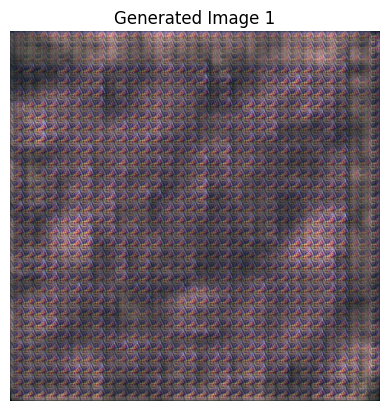

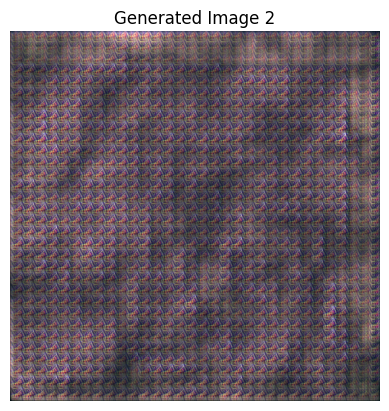

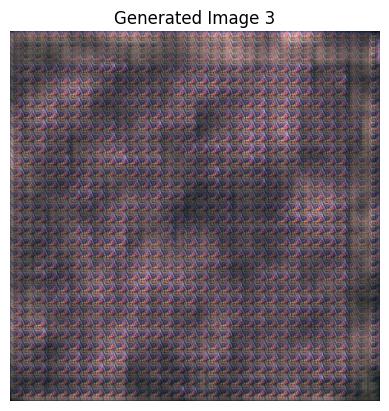

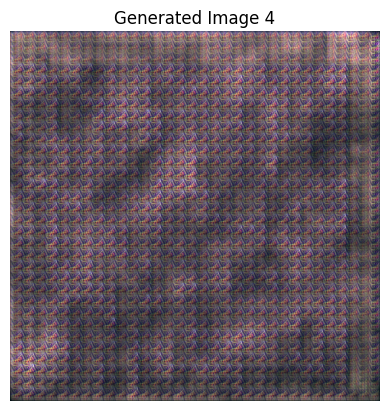

In [6]:
import matplotlib.pyplot as plt

# Move generated images to CPU and normalize to [0, 1] range if necessary
generated_images = generated_images.cpu().detach().clamp(0, 1)  # Ensure values are within [0, 1]

# Plot each image
for i, img in enumerate(generated_images):
    plt.figure()
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert from (C, H, W) to (H, W, C)
    plt.title(f"Generated Image {i + 1}")
    plt.axis('off')
    plt.show()
